# CAPM and Efficient frontier portfolio optimisation

In this project we will look for optimal equity portfolio mixes, given a set of specifiad asses, to create a mix that maximizes different investment objectives (Returns, Risk, Sharpe Ratio). We will utilise the assumptions included in Moden Portfolio Theory to generate the base CAPM model. 

In order to achieve this, we will aim to follow the flow below:

1. Retrieve the data from the desired list of portfolio assets
2. Generate a random set of Portfolio (i.e random asset allocation mixes)
3. Generate a plot of risk and return combinations for the portfolios generated
4. Find the optimal mix for maximizing the given objective, based on the generated Portfolio population

## Setting and retrieving the data
For this excercise we will arbitrarily select 4 different tech stocks.
1. Google (GOOGL)
2. Tencent (TCEHY)
3. AMD (AMD)
4. Qualcomm (QCOM)

We will take bi-annual the data between:  
04/01/2019 - 04/01/2021

To retrieve the data we can utilise the pandas web module to fetch Market Close prices for the portfolio.

The data source will be Yahoo (as it is an easily accessible free online source) and the price will be the Adjusted Close Price.

In [1]:
import pandas_datareader as web
import pandas as pd
import numpy as np

data = {}

#tickers = ['GOOGL', 'TCEHY', 'AMD','QCOM']
#
tickers = ['GOOGL', 'TM', 'KO', 'PEP']

numAssets = len(tickers) #Stores the number of assets in the list

#for symbol in tickers:
#    data[symbol] = web.DataReader(symbol, data_source = 'yahoo', start = '2019-04-01', end = '2021-04-01')['Adj Close']
for symbol in tickers:
    data[symbol] = web.DataReader(symbol, data_source = 'yahoo', start = '2010-01-01', end = '2015-10-30')['Adj Close']

Now that we have the pricing data stored in the *data* dicionary, we perform the calucaltion for the mean, variance and covariance to arrive at the base parameters for simulation.

Note: we add a *dur* variable, as we will be working in monthly return space, whereas the data fetched is daily. This allows us to take every 20-th business day (which will be one of our assumptions).

In [2]:
data_frame = pd.DataFrame.from_dict(data)

In [30]:
dur = 20 #Since we want to work with monthly, rather than daily returns. Assuming 
data = data_frame
data = data[::dur]
data

,GOOGL,TM,KO,PEP
Date,,,,
2010-01-04,313.688690,72.314583,20.098238,43.941441
2010-02-02,265.825836,66.449860,19.397055,43.876858
2010-03-03,272.932922,65.395905,19.002419,46.233562
2010-03-31,283.843842,68.955505,19.538046,47.808884
2010-04-29,266.266266,66.974808,19.090450,47.115166
...,...,...,...,...
2015-06-29,541.250000,126.288643,32.633152,79.052788
2015-07-28,659.659973,125.707016,33.585648,81.094719
2015-08-25,612.469971,108.096222,31.465321,75.635521


In [31]:
# Log Returns

returns = np.log(data/data.shift(1))
returns

,GOOGL,TM,KO,PEP
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-02-02,-0.165560,-0.084578,-0.035511,-0.001471
2010-03-03,0.026385,-0.015988,-0.020555,0.052319
2010-03-31,0.039198,0.053002,0.027797,0.033505
2010-04-29,-0.063927,-0.029145,-0.023175,-0.014617
...,...,...,...,...
2015-06-29,-0.014600,-0.035526,-0.030126,-0.016698
2015-07-28,0.197843,-0.004616,0.028770,0.025502
2015-08-25,-0.074225,-0.150932,-0.065213,-0.069692


In [32]:
#Calculate the parameters mean returns and covariance between the stocks
meanDailyReturns = returns.mean()
covMatrix = returns.cov()
meanDailyReturns, covMatrix

(GOOGL    0.010432
 TM       0.006891
 KO       0.007695
 PEP      0.009078
 dtype: float64,
           GOOGL        TM        KO       PEP
 GOOGL  0.005022  0.000913  0.000870  0.000528
 TM     0.000913  0.003332  0.000514  0.000663
 KO     0.000870  0.000514  0.001451  0.000868
 PEP    0.000528  0.000663  0.000868  0.001238)

## Evaluating risk-return profile for a given portfolio

If we want to calcualte the risk return profile for a set of given weight, we can apply the calucalted parameters

In [33]:
#Calculate expected portfolio performance
weights = [0.5, 0.2, 0.2, 0.1]
portReturn = np.sum( meanDailyReturns*weights )
portStdDev = np.sqrt(np.dot(weights, np.dot(covMatrix, weights)))

In [34]:
print('The daily  return profile is ' + str(portReturn), ' The daily STDev of the portfolio is ' + str(portStdDev))

The daily  return profile is 0.009041097809964682  The daily STDev of the portfolio is 0.04439354046341765


We now turn our heads into optimizing the portfolio itself. We have generated a risk-reutnr profile for an individdually selected weight of the set of assets , however in order to find an optimal mix we will look to Monte-Carlo simulation to generate sets of portfolios.

## Monte Carlo Method to optimizing a portfolio
In this section we will generate sets of protflio, with our 4 selected assets. Once genreated, we will observe the efficient frontier and find portfolio that optimize our objective. 

In [35]:
#Creating an empty list of lists to store our results for Daily Returns, Annual Returns and Sharpe Ratios, for 2500 simulations
numPortfolios = 25000
results = np.zeros((3, numPortfolios))

We first define a function that caluclate the return, volatility and covariance matrix for a gien portfolio (as done previously)m so that we can apply it for a larger set of potrfolios in a loop.

In [36]:
def calcPortfolioPerf(weights, meanReturns, covMatrix):

    #Calculate return and variance
    portReturn = np.sum( meanReturns*weights )
    portStdDev = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))

    return portReturn, portStdDev

We then randomly generate portfolio weights and calcualte the parameters using the defined function. Note that the return and volatility is annualized. We perform 2500 simulations.

In [37]:
meanDailyReturns = returns.mean()
covMatrix = returns.cov()
numPeriodsAnnually = 252

dur = 20 # we divide the data population and 
numPeriodsAnnually = 252.0 / dur
riskFreeRate = 0.0021 # Baseds onj 16 year treasury rate as of 2021-04-14, Source: YCharts

for i in range(numPortfolios):
    #Draw numAssets random numbers from a uniform distribution and normalize them to be the portfolio weights
    weights = np.random.random(numAssets)
    weights /= np.sum(weights)
    
    
    #Calculate expected return and volatility of portfolio
    pret, pvar = calcPortfolioPerf(weights, meanDailyReturns, covMatrix)

    #Convert results to annual basis, calculate Sharpe Ratio, and store them
    results[0,i] = pret*numPeriodsAnnually
    results[1,i] = pvar*np.sqrt(numPeriodsAnnually)
    results[2,i] = (results[0,i] - riskFreeRate)/results[1,i]

Now Plotting the simulation results:

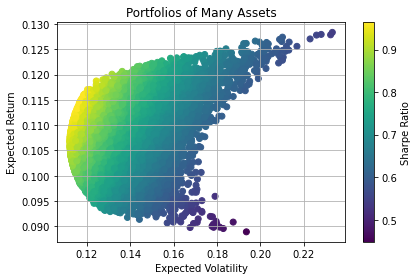

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm
from collections import OrderedDict

plt.set_cmap('viridis')
plt.scatter(results[1,:], results[0,:], c=results[2,:], marker='o', cmap = 'viridis')

plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolios of Many Assets')
plt.tight_layout()
plt.savefig('Monte Carlo Simulation for Portfolio', dpi=100)



The above plot shows the reisk-return profiles for the 2500 simualted portfolios.
Now that we we have genrated these profiles, we turn our heads to optimization, i.e we will be looking at which portfolio mix in the gnerated set offers the best risk-reward profile. Futher, given the simulated set, we will look at choosing a portfolio that Maximiez our Sharp Ratio and Minimizes our Risk. 


# Portfolio Optimization

Based on the insights from Figure 1, it is evident that a target return can be achieved with a wide range of risk levels. This introduces the concept of the “Efficient Frontier.” The Efficient Frontier is the set of portfolios that achieve a given return with the minimum amount of risk for that return. On the graph, it is the left most boundary that the scatter population projects.

To simplify the Sharpe ratio operation, we define an additional function to compute the Sharpe ratio, rather than specifying it seperately in the loop

In [39]:
def SharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    '''
    Returns the Sharpe Ratio for the speicified portfolio of assets

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    p_ret, p_var = calcPortfolioPerf(weights, meanReturns, covMatrix)

    return (p_ret - riskFreeRate) / p_var

def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    negSharp = SharpeRatio(weights, meanReturns, covMatrix, riskFreeRate)*(-1)
    #Flips the sharpe ratio so that It can be utilised in the SciPy minimzation function
    return negSharp

We nowthat we ahve the functions that allows to the parameters and statistics of each portfolio, we create a function to finx the portfolio with the maximum Sharpe Ratio. 

In [40]:
import scipy.optimize as sco

def findMaxSharpeRatioPortfolio(meanReturns, covMatrix, riskFreeRate):
    '''
    Finds the portfolio of assets providing the maximum Sharpe Ratio

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(negSharpeRatio, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return opts


In [41]:
maxSharpe = findMaxSharpeRatioPortfolio(meanDailyReturns, covMatrix, riskFreeRate)

And so the array of weights is is returned in *maxSharpe*

In [42]:
maxSharpe


     fun: -0.21300645908554475
     jac: array([-0.06256174, -0.06324579, -0.06296065, -0.06274492])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.170439  , 0.01813788, 0.02739017, 0.78403295])

In [43]:
print(maxSharpe['x'].sum())

1.0


Now that we have the required weight, we caluclate the portfolio risk-return profile, using the 'calcPortfolioPerf' function.

In [44]:
weights = maxSharpe['x']
meanReturns = np.sum( meanDailyReturns*weights )
rp, sdp = calcPortfolioPerf(weights, meanReturns, covMatrix)

Then converting from daily to annual returns

In [45]:
rp =rp * numPeriodsAnnually
sdp = sdp * np.sqrt(numPeriodsAnnually)

Which ring us the desired pair of the Portfolio Standard Deviation and Expected Return

In [51]:
print(sdp, rp)

0.11883334033246769 0.11630964189877013


Graphin the point onto our portfolio collection we obtain the following

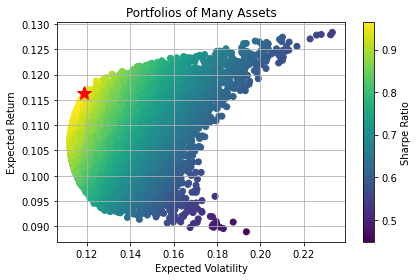

In [48]:
plt.scatter(results[1,:], results[0,:], c=results[2,:], marker='o', cmap = 'viridis')
plt.plot(sdp, rp, 'r*', markersize=15.0)

plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolios of Many Assets')
plt.tight_layout()
plt.savefig('Monte Carlo Simulation for Portfolio', dpi=100)

plt.show()

In [49]:
plt.show()